In [1]:


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import resnet18,resnet34,resnet50,resnet101,resnet152
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data.sampler import WeightedRandomSampler

import matplotlib.pyplot as plt
import numpy as np
import random
import os

c:\Users\zhChe\anaconda3\envs\lane-det\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define your custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
        self.classes = self.data.classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        return img, label

In [3]:
# Set up data transformations
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.2582, 0.2476, 0.2308], std=[0.3044, 0.2925, 0.2736]),
])

data_dir = 'D:\GoogleStreetView\Rumble Strip.v5i.folder'
# Load your custom dataset
train_data = CustomDataset(data_dir + '/train', transform=transform)
# test_data = CustomDataset(data_dir + '/test', transform=transform)
val_data = CustomDataset(data_dir + '/valid', transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [4]:
mean = np.zeros(3)
std = np.zeros(3)
for data, _ in val_data:
    for i in range(3):
        mean[i] += data[i].mean()
        std[i] += data[i].std()
mean /= len(val_data)
std /= len(val_data)
print(mean)
print(std)

[0.25284926 0.24247598 0.22644274]
[0.28620115 0.27481708 0.25584187]


In [5]:
mean = np.zeros(3)
std = np.zeros(3)
for data, _ in train_data:
    for i in range(3):
        mean[i] += data[i].mean()
        std[i] += data[i].std()
mean /= len(train_data)
std /= len(train_data)
print(mean)
print(std)

In [ ]:
# calculate number labels with 1 and 0
def count_labels(loader):
    labels = []
    for _, label in loader:
        labels.extend(label.numpy())
    return labels

train_labels = count_labels(train_loader)


In [ ]:
np.unique(train_labels,return_counts=True)

(array([0, 1], dtype=int64), array([5397, 2622], dtype=int64))

In [ ]:
# Set up data transformations
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    # add some data augmentation
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    # lighting conditions
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.Normalize(mean=[0.25257042,0.24238083,0.22564004], std=[0.28864914,0.27758299,0.25838134]),
])

data_dir = 'D:\GoogleStreetView\Rumble Strip.v5i.folder'
# Load your custom dataset
train_data = CustomDataset(data_dir + '/train', transform=transform)
# test_data = CustomDataset(data_dir + '/test', transform=transform)
val_data = CustomDataset(data_dir + '/valid', transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [ ]:
# Calculate class weights for WeightedRandomSampler
class_counts = [5397, 2622]  # Replace with actual class counts
num_samples = sum(class_counts)
class_weights = [num_samples / count for count in class_counts]
weights = [class_weights[label] for label in train_labels]
# Create WeightedRandomSampler
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), len(weights))
# Create data loaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, sampler = sampler)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train samples: 8019
Validation samples: 531
Classes: ['Absent', 'Present']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


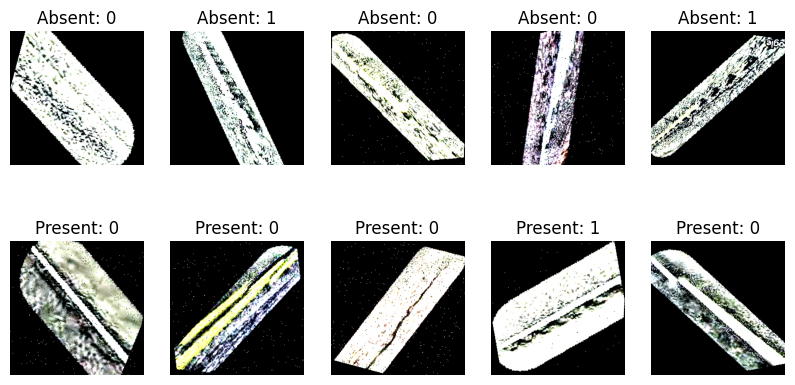

In [ ]:
# print the number of samples in each set
print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
# print(f"Test samples: {len(test_data)}")
# print the number of classes
print(f"Classes: {train_data.classes}")
# plot some samples in the training set, 5 absent and 5 present

plt.figure(figsize=(10, 5))
for i in range(5):
    idx = random.randint(0, len(train_data))
    img, label = train_data[idx]
    plt.subplot(2, 5, i+1)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(f"Absent: {label}")
    plt.axis('off')
for i in range(5):
    idx = random.randint(0, len(train_data))
    img, label = train_data[idx]
    plt.subplot(2, 5, i+6)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(f"Present: {label}")
    plt.axis('off')
plt.show()



In [ ]:
from torchvision.models import resnet18,resnet34,resnet50,resnet101,resnet152

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')
# Define ResNet model
model = resnet34(pretrained=True)
num_classes = len(train_data.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)
# Set up optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Adjust step_size and gamma as needed
criterion = nn.CrossEntropyLoss()

Using cuda for inference


In [28]:
# Training loop
num_epochs = 200
# save_interval = 10
best_val_accuracy = 0.0
best_epoch = 0
best_f1_socre = 0
save_path = r'D:\GoogleStreetView\TrainingRes34'
if not os.path.exists(save_path):
    os.makedirs(save_path)
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true_labels.extend(labels.tolist())
            predicted_labels.extend(predicted.tolist())

    val_accuracy = 100 * correct / total
    precision = precision_score(true_labels, predicted_labels, average='binary')
    recall = recall_score(true_labels, predicted_labels, average='binary')
    f1 = f1_score(true_labels, predicted_labels, average='binary')

    print(f"Epoch [{epoch+1}/{num_epochs}]: Val Loss: {val_loss:.4f}, Train Loss: {train_loss:.4f},Val Acc: {val_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    # Save best model checkpoint
    if f1 > best_f1_socre:
        best_f1_socre = f1
        best_epoch = epoch
        torch.save(model.state_dict(), os.path.join(save_path,'resnet_custom_model_best.pth'))


    torch.save(model.state_dict(), os.path.join(save_path,f'last_epoch.pth'))
    print(f"Saved model checkpoint at epoch {epoch+1} to {save_path}")

# Final save after all epochs
torch.save(model.state_dict(), 'resnet_custom_model_final.pth')
print(f"Best model achieved at epoch {best_epoch+1} with validation accuracy {best_val_accuracy:.2f}%")

100%|██████████| 126/126 [02:42<00:00,  1.29s/it]


Epoch [1/200]: Val Loss: 4.1375, Train Loss: 11.1331,Val Acc: 88.70%
Precision: 0.7880, Recall: 0.8735, F1-score: 0.8286
Saved model checkpoint at epoch 1 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:35<00:00,  1.23s/it]


Epoch [2/200]: Val Loss: 4.1983, Train Loss: 10.9738,Val Acc: 89.45%
Precision: 0.8313, Recall: 0.8313, F1-score: 0.8313
Saved model checkpoint at epoch 2 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:29<00:00,  1.19s/it]


Epoch [3/200]: Val Loss: 4.1351, Train Loss: 11.7909,Val Acc: 87.95%
Precision: 0.7602, Recall: 0.8976, F1-score: 0.8232
Saved model checkpoint at epoch 3 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:29<00:00,  1.19s/it]


Epoch [4/200]: Val Loss: 2.9727, Train Loss: 12.5786,Val Acc: 91.34%
Precision: 0.8488, Recall: 0.8795, F1-score: 0.8639
Saved model checkpoint at epoch 4 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:30<00:00,  1.19s/it]


Epoch [5/200]: Val Loss: 6.0821, Train Loss: 9.4353,Val Acc: 89.83%
Precision: 0.8944, Recall: 0.7651, F1-score: 0.8247
Saved model checkpoint at epoch 5 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [6/200]: Val Loss: 4.3221, Train Loss: 10.8007,Val Acc: 89.08%
Precision: 0.7872, Recall: 0.8916, F1-score: 0.8362
Saved model checkpoint at epoch 6 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [7/200]: Val Loss: 3.5943, Train Loss: 10.4087,Val Acc: 90.58%
Precision: 0.8537, Recall: 0.8434, F1-score: 0.8485
Saved model checkpoint at epoch 7 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.16s/it]


Epoch [8/200]: Val Loss: 2.8073, Train Loss: 9.5112,Val Acc: 90.77%
Precision: 0.8545, Recall: 0.8494, F1-score: 0.8520
Saved model checkpoint at epoch 8 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [9/200]: Val Loss: 4.4343, Train Loss: 8.5275,Val Acc: 88.51%
Precision: 0.7749, Recall: 0.8916, F1-score: 0.8291
Saved model checkpoint at epoch 9 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [10/200]: Val Loss: 4.0662, Train Loss: 9.4724,Val Acc: 91.53%
Precision: 0.8667, Recall: 0.8614, F1-score: 0.8640
Saved model checkpoint at epoch 10 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [11/200]: Val Loss: 4.5041, Train Loss: 10.6182,Val Acc: 89.08%
Precision: 0.8375, Recall: 0.8072, F1-score: 0.8221
Saved model checkpoint at epoch 11 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [12/200]: Val Loss: 5.7356, Train Loss: 10.5558,Val Acc: 89.45%
Precision: 0.8873, Recall: 0.7590, F1-score: 0.8182
Saved model checkpoint at epoch 12 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [13/200]: Val Loss: 3.8105, Train Loss: 8.6389,Val Acc: 89.45%
Precision: 0.7895, Recall: 0.9036, F1-score: 0.8427
Saved model checkpoint at epoch 13 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:30<00:00,  1.19s/it]


Epoch [14/200]: Val Loss: 4.4503, Train Loss: 8.3725,Val Acc: 90.77%
Precision: 0.8503, Recall: 0.8554, F1-score: 0.8529
Saved model checkpoint at epoch 14 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [15/200]: Val Loss: 4.9360, Train Loss: 8.4072,Val Acc: 90.58%
Precision: 0.8452, Recall: 0.8554, F1-score: 0.8503
Saved model checkpoint at epoch 15 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [16/200]: Val Loss: 5.1724, Train Loss: 9.0805,Val Acc: 88.51%
Precision: 0.8182, Recall: 0.8133, F1-score: 0.8157
Saved model checkpoint at epoch 16 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [17/200]: Val Loss: 3.6757, Train Loss: 10.1681,Val Acc: 90.40%
Precision: 0.8443, Recall: 0.8494, F1-score: 0.8468
Saved model checkpoint at epoch 17 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:29<00:00,  1.19s/it]


Epoch [18/200]: Val Loss: 5.0483, Train Loss: 8.0762,Val Acc: 87.76%
Precision: 0.7730, Recall: 0.8614, F1-score: 0.8148
Saved model checkpoint at epoch 18 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [19/200]: Val Loss: 4.9398, Train Loss: 8.4591,Val Acc: 89.45%
Precision: 0.8313, Recall: 0.8313, F1-score: 0.8313
Saved model checkpoint at epoch 19 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.17s/it]


Epoch [20/200]: Val Loss: 4.0989, Train Loss: 7.9674,Val Acc: 90.21%
Precision: 0.8701, Recall: 0.8072, F1-score: 0.8375
Saved model checkpoint at epoch 20 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [21/200]: Val Loss: 4.0985, Train Loss: 7.6734,Val Acc: 89.45%
Precision: 0.8056, Recall: 0.8735, F1-score: 0.8382
Saved model checkpoint at epoch 21 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [22/200]: Val Loss: 6.8607, Train Loss: 7.2924,Val Acc: 89.45%
Precision: 0.8873, Recall: 0.7590, F1-score: 0.8182
Saved model checkpoint at epoch 22 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [23/200]: Val Loss: 5.9869, Train Loss: 7.4608,Val Acc: 89.08%
Precision: 0.8034, Recall: 0.8614, F1-score: 0.8314
Saved model checkpoint at epoch 23 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [24/200]: Val Loss: 4.4029, Train Loss: 8.7747,Val Acc: 88.14%
Precision: 0.7614, Recall: 0.9036, F1-score: 0.8264
Saved model checkpoint at epoch 24 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [25/200]: Val Loss: 5.6672, Train Loss: 7.3505,Val Acc: 88.14%
Precision: 0.7943, Recall: 0.8373, F1-score: 0.8152
Saved model checkpoint at epoch 25 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [26/200]: Val Loss: 4.3427, Train Loss: 7.0852,Val Acc: 91.90%
Precision: 0.8555, Recall: 0.8916, F1-score: 0.8732
Saved model checkpoint at epoch 26 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:29<00:00,  1.18s/it]


Epoch [27/200]: Val Loss: 4.2549, Train Loss: 6.8922,Val Acc: 90.96%
Precision: 0.8598, Recall: 0.8494, F1-score: 0.8545
Saved model checkpoint at epoch 27 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:29<00:00,  1.18s/it]


Epoch [28/200]: Val Loss: 5.1370, Train Loss: 7.8459,Val Acc: 89.83%
Precision: 0.8182, Recall: 0.8675, F1-score: 0.8421
Saved model checkpoint at epoch 28 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:29<00:00,  1.19s/it]


Epoch [29/200]: Val Loss: 5.2670, Train Loss: 6.8535,Val Acc: 90.02%
Precision: 0.8304, Recall: 0.8554, F1-score: 0.8427
Saved model checkpoint at epoch 29 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [30/200]: Val Loss: 7.8434, Train Loss: 9.1827,Val Acc: 88.89%
Precision: 0.8741, Recall: 0.7530, F1-score: 0.8091
Saved model checkpoint at epoch 30 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [31/200]: Val Loss: 5.2189, Train Loss: 7.1491,Val Acc: 89.27%
Precision: 0.8344, Recall: 0.8193, F1-score: 0.8267
Saved model checkpoint at epoch 31 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:38<00:00,  1.25s/it]


Epoch [32/200]: Val Loss: 4.6354, Train Loss: 5.7164,Val Acc: 90.40%
Precision: 0.8443, Recall: 0.8494, F1-score: 0.8468
Saved model checkpoint at epoch 32 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:38<00:00,  1.26s/it]


Epoch [33/200]: Val Loss: 4.4910, Train Loss: 6.1468,Val Acc: 90.96%
Precision: 0.9041, Recall: 0.7952, F1-score: 0.8462
Saved model checkpoint at epoch 33 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:32<00:00,  1.21s/it]


Epoch [34/200]: Val Loss: 4.0774, Train Loss: 7.1398,Val Acc: 91.34%
Precision: 0.8614, Recall: 0.8614, F1-score: 0.8614
Saved model checkpoint at epoch 34 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:29<00:00,  1.19s/it]


Epoch [35/200]: Val Loss: 6.1993, Train Loss: 5.1030,Val Acc: 89.45%
Precision: 0.8354, Recall: 0.8253, F1-score: 0.8303
Saved model checkpoint at epoch 35 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:29<00:00,  1.18s/it]


Epoch [36/200]: Val Loss: 5.7557, Train Loss: 6.0043,Val Acc: 90.58%
Precision: 0.8766, Recall: 0.8133, F1-score: 0.8438
Saved model checkpoint at epoch 36 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [37/200]: Val Loss: 5.1941, Train Loss: 6.2981,Val Acc: 91.34%
Precision: 0.8947, Recall: 0.8193, F1-score: 0.8553
Saved model checkpoint at epoch 37 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [38/200]: Val Loss: 5.5493, Train Loss: 6.2323,Val Acc: 89.08%
Precision: 0.8253, Recall: 0.8253, F1-score: 0.8253
Saved model checkpoint at epoch 38 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [39/200]: Val Loss: 4.3128, Train Loss: 5.5828,Val Acc: 89.45%
Precision: 0.8090, Recall: 0.8675, F1-score: 0.8372
Saved model checkpoint at epoch 39 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [40/200]: Val Loss: 4.2372, Train Loss: 6.3840,Val Acc: 91.34%
Precision: 0.8704, Recall: 0.8494, F1-score: 0.8598
Saved model checkpoint at epoch 40 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [41/200]: Val Loss: 5.3470, Train Loss: 5.5446,Val Acc: 92.09%
Precision: 0.8690, Recall: 0.8795, F1-score: 0.8743
Saved model checkpoint at epoch 41 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [42/200]: Val Loss: 5.3157, Train Loss: 6.1231,Val Acc: 88.14%
Precision: 0.7725, Recall: 0.8795, F1-score: 0.8225
Saved model checkpoint at epoch 42 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [43/200]: Val Loss: 4.9974, Train Loss: 5.3245,Val Acc: 90.21%
Precision: 0.8519, Recall: 0.8313, F1-score: 0.8415
Saved model checkpoint at epoch 43 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [44/200]: Val Loss: 6.3190, Train Loss: 6.2507,Val Acc: 88.14%
Precision: 0.8705, Recall: 0.7289, F1-score: 0.7934
Saved model checkpoint at epoch 44 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [45/200]: Val Loss: 4.5915, Train Loss: 5.7235,Val Acc: 92.47%
Precision: 0.9200, Recall: 0.8313, F1-score: 0.8734
Saved model checkpoint at epoch 45 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [46/200]: Val Loss: 5.4626, Train Loss: 5.1524,Val Acc: 90.58%
Precision: 0.8816, Recall: 0.8072, F1-score: 0.8428
Saved model checkpoint at epoch 46 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [47/200]: Val Loss: 6.8429, Train Loss: 5.3283,Val Acc: 88.51%
Precision: 0.8889, Recall: 0.7229, F1-score: 0.7973
Saved model checkpoint at epoch 47 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.17s/it]


Epoch [48/200]: Val Loss: 6.4660, Train Loss: 4.0660,Val Acc: 90.40%
Precision: 0.8571, Recall: 0.8313, F1-score: 0.8440
Saved model checkpoint at epoch 48 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [49/200]: Val Loss: 5.6422, Train Loss: 6.3187,Val Acc: 90.40%
Precision: 0.8758, Recall: 0.8072, F1-score: 0.8401
Saved model checkpoint at epoch 49 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:30<00:00,  1.19s/it]


Epoch [50/200]: Val Loss: 5.5263, Train Loss: 5.4962,Val Acc: 90.40%
Precision: 0.8859, Recall: 0.7952, F1-score: 0.8381
Saved model checkpoint at epoch 50 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:29<00:00,  1.19s/it]


Epoch [51/200]: Val Loss: 5.0249, Train Loss: 4.6938,Val Acc: 90.77%
Precision: 0.8726, Recall: 0.8253, F1-score: 0.8483
Saved model checkpoint at epoch 51 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:29<00:00,  1.19s/it]


Epoch [52/200]: Val Loss: 4.6606, Train Loss: 5.2558,Val Acc: 90.58%
Precision: 0.8412, Recall: 0.8614, F1-score: 0.8512
Saved model checkpoint at epoch 52 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [53/200]: Val Loss: 5.6514, Train Loss: 4.0798,Val Acc: 91.53%
Precision: 0.8954, Recall: 0.8253, F1-score: 0.8589
Saved model checkpoint at epoch 53 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [54/200]: Val Loss: 4.4534, Train Loss: 5.5710,Val Acc: 91.15%
Precision: 0.8606, Recall: 0.8554, F1-score: 0.8580
Saved model checkpoint at epoch 54 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.17s/it]


Epoch [55/200]: Val Loss: 6.3819, Train Loss: 5.6660,Val Acc: 90.21%
Precision: 0.8701, Recall: 0.8072, F1-score: 0.8375
Saved model checkpoint at epoch 55 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.17s/it]


Epoch [56/200]: Val Loss: 3.6170, Train Loss: 4.7031,Val Acc: 91.90%
Precision: 0.8596, Recall: 0.8855, F1-score: 0.8724
Saved model checkpoint at epoch 56 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [57/200]: Val Loss: 5.7853, Train Loss: 3.5858,Val Acc: 89.64%
Precision: 0.8246, Recall: 0.8494, F1-score: 0.8368
Saved model checkpoint at epoch 57 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [58/200]: Val Loss: 4.6975, Train Loss: 5.6451,Val Acc: 91.90%
Precision: 0.8968, Recall: 0.8373, F1-score: 0.8660
Saved model checkpoint at epoch 58 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [59/200]: Val Loss: 5.7786, Train Loss: 3.6375,Val Acc: 90.40%
Precision: 0.8402, Recall: 0.8554, F1-score: 0.8478
Saved model checkpoint at epoch 59 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.16s/it]


Epoch [60/200]: Val Loss: 5.0913, Train Loss: 4.9194,Val Acc: 92.47%
Precision: 0.8750, Recall: 0.8855, F1-score: 0.8802
Saved model checkpoint at epoch 60 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [61/200]: Val Loss: 6.2393, Train Loss: 4.8229,Val Acc: 89.45%
Precision: 0.8767, Recall: 0.7711, F1-score: 0.8205
Saved model checkpoint at epoch 61 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [62/200]: Val Loss: 4.7767, Train Loss: 6.1915,Val Acc: 89.27%
Precision: 0.8045, Recall: 0.8675, F1-score: 0.8348
Saved model checkpoint at epoch 62 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [63/200]: Val Loss: 5.2578, Train Loss: 4.8567,Val Acc: 88.51%
Precision: 0.8261, Recall: 0.8012, F1-score: 0.8135
Saved model checkpoint at epoch 63 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [64/200]: Val Loss: 4.7228, Train Loss: 3.4684,Val Acc: 90.96%
Precision: 0.8688, Recall: 0.8373, F1-score: 0.8528
Saved model checkpoint at epoch 64 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.16s/it]


Epoch [65/200]: Val Loss: 5.7652, Train Loss: 4.7569,Val Acc: 90.96%
Precision: 0.8598, Recall: 0.8494, F1-score: 0.8545
Saved model checkpoint at epoch 65 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [66/200]: Val Loss: 4.4202, Train Loss: 4.0572,Val Acc: 91.34%
Precision: 0.8571, Recall: 0.8675, F1-score: 0.8623
Saved model checkpoint at epoch 66 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [67/200]: Val Loss: 5.7737, Train Loss: 3.5371,Val Acc: 91.90%
Precision: 0.8683, Recall: 0.8735, F1-score: 0.8709
Saved model checkpoint at epoch 67 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [68/200]: Val Loss: 5.8071, Train Loss: 3.2204,Val Acc: 91.34%
Precision: 0.8409, Recall: 0.8916, F1-score: 0.8655
Saved model checkpoint at epoch 68 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.16s/it]


Epoch [69/200]: Val Loss: 4.4791, Train Loss: 4.7074,Val Acc: 90.77%
Precision: 0.8232, Recall: 0.8976, F1-score: 0.8588
Saved model checkpoint at epoch 69 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.17s/it]


Epoch [70/200]: Val Loss: 4.8593, Train Loss: 4.4410,Val Acc: 90.21%
Precision: 0.8519, Recall: 0.8313, F1-score: 0.8415
Saved model checkpoint at epoch 70 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [71/200]: Val Loss: 5.3318, Train Loss: 3.7153,Val Acc: 90.02%
Precision: 0.8509, Recall: 0.8253, F1-score: 0.8379
Saved model checkpoint at epoch 71 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [72/200]: Val Loss: 6.7377, Train Loss: 4.2944,Val Acc: 89.64%
Precision: 0.8581, Recall: 0.8012, F1-score: 0.8287
Saved model checkpoint at epoch 72 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [73/200]: Val Loss: 6.3336, Train Loss: 4.8862,Val Acc: 89.45%
Precision: 0.8571, Recall: 0.7952, F1-score: 0.8250
Saved model checkpoint at epoch 73 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [74/200]: Val Loss: 4.9838, Train Loss: 5.0234,Val Acc: 91.53%
Precision: 0.9007, Recall: 0.8193, F1-score: 0.8580
Saved model checkpoint at epoch 74 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [75/200]: Val Loss: 5.1976, Train Loss: 5.0950,Val Acc: 91.15%
Precision: 0.8650, Recall: 0.8494, F1-score: 0.8571
Saved model checkpoint at epoch 75 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.16s/it]


Epoch [76/200]: Val Loss: 7.0395, Train Loss: 4.5667,Val Acc: 90.40%
Precision: 0.8710, Recall: 0.8133, F1-score: 0.8411
Saved model checkpoint at epoch 76 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.16s/it]


Epoch [77/200]: Val Loss: 6.1810, Train Loss: 5.0497,Val Acc: 88.89%
Precision: 0.8204, Recall: 0.8253, F1-score: 0.8228
Saved model checkpoint at epoch 77 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [78/200]: Val Loss: 5.8369, Train Loss: 3.3297,Val Acc: 90.02%
Precision: 0.8424, Recall: 0.8373, F1-score: 0.8399
Saved model checkpoint at epoch 78 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.17s/it]


Epoch [79/200]: Val Loss: 5.4809, Train Loss: 3.2241,Val Acc: 91.90%
Precision: 0.8596, Recall: 0.8855, F1-score: 0.8724
Saved model checkpoint at epoch 79 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.16s/it]


Epoch [80/200]: Val Loss: 6.2566, Train Loss: 3.1756,Val Acc: 89.45%
Precision: 0.8161, Recall: 0.8554, F1-score: 0.8353
Saved model checkpoint at epoch 80 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.16s/it]


Epoch [81/200]: Val Loss: 4.0068, Train Loss: 4.5833,Val Acc: 91.34%
Precision: 0.8614, Recall: 0.8614, F1-score: 0.8614
Saved model checkpoint at epoch 81 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [82/200]: Val Loss: 6.5057, Train Loss: 3.4746,Val Acc: 89.08%
Precision: 0.8176, Recall: 0.8373, F1-score: 0.8274
Saved model checkpoint at epoch 82 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.17s/it]


Epoch [83/200]: Val Loss: 5.2691, Train Loss: 3.7840,Val Acc: 91.15%
Precision: 0.8650, Recall: 0.8494, F1-score: 0.8571
Saved model checkpoint at epoch 83 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.17s/it]


Epoch [84/200]: Val Loss: 5.1935, Train Loss: 4.7434,Val Acc: 90.96%
Precision: 0.8315, Recall: 0.8916, F1-score: 0.8605
Saved model checkpoint at epoch 84 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [85/200]: Val Loss: 5.2483, Train Loss: 3.4884,Val Acc: 90.02%
Precision: 0.8122, Recall: 0.8855, F1-score: 0.8473
Saved model checkpoint at epoch 85 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [86/200]: Val Loss: 5.9185, Train Loss: 3.2132,Val Acc: 90.58%
Precision: 0.8295, Recall: 0.8795, F1-score: 0.8538
Saved model checkpoint at epoch 86 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [87/200]: Val Loss: 6.5020, Train Loss: 3.1522,Val Acc: 90.40%
Precision: 0.8363, Recall: 0.8614, F1-score: 0.8487
Saved model checkpoint at epoch 87 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [88/200]: Val Loss: 4.4726, Train Loss: 4.1238,Val Acc: 91.90%
Precision: 0.9128, Recall: 0.8193, F1-score: 0.8635
Saved model checkpoint at epoch 88 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [89/200]: Val Loss: 5.9791, Train Loss: 2.8813,Val Acc: 89.64%
Precision: 0.8208, Recall: 0.8554, F1-score: 0.8378
Saved model checkpoint at epoch 89 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [90/200]: Val Loss: 7.3678, Train Loss: 3.0479,Val Acc: 89.45%
Precision: 0.8716, Recall: 0.7771, F1-score: 0.8217
Saved model checkpoint at epoch 90 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [91/200]: Val Loss: 5.7115, Train Loss: 2.9125,Val Acc: 91.53%
Precision: 0.8805, Recall: 0.8434, F1-score: 0.8615
Saved model checkpoint at epoch 91 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.16s/it]


Epoch [92/200]: Val Loss: 9.2668, Train Loss: 4.0896,Val Acc: 89.83%
Precision: 0.9118, Recall: 0.7470, F1-score: 0.8212
Saved model checkpoint at epoch 92 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [93/200]: Val Loss: 4.7840, Train Loss: 4.1687,Val Acc: 91.15%
Precision: 0.8742, Recall: 0.8373, F1-score: 0.8554
Saved model checkpoint at epoch 93 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.17s/it]


Epoch [94/200]: Val Loss: 6.1150, Train Loss: 3.2064,Val Acc: 90.40%
Precision: 0.8758, Recall: 0.8072, F1-score: 0.8401
Saved model checkpoint at epoch 94 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [95/200]: Val Loss: 5.3064, Train Loss: 3.7341,Val Acc: 89.64%
Precision: 0.8136, Recall: 0.8675, F1-score: 0.8397
Saved model checkpoint at epoch 95 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.16s/it]


Epoch [96/200]: Val Loss: 5.3036, Train Loss: 2.4967,Val Acc: 89.64%
Precision: 0.8675, Recall: 0.7892, F1-score: 0.8265
Saved model checkpoint at epoch 96 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [97/200]: Val Loss: 5.2918, Train Loss: 2.7046,Val Acc: 90.96%
Precision: 0.8471, Recall: 0.8675, F1-score: 0.8571
Saved model checkpoint at epoch 97 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [98/200]: Val Loss: 5.5155, Train Loss: 4.1878,Val Acc: 90.40%
Precision: 0.8710, Recall: 0.8133, F1-score: 0.8411
Saved model checkpoint at epoch 98 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [99/200]: Val Loss: 6.2907, Train Loss: 3.6470,Val Acc: 90.21%
Precision: 0.8701, Recall: 0.8072, F1-score: 0.8375
Saved model checkpoint at epoch 99 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [100/200]: Val Loss: 5.5424, Train Loss: 3.8149,Val Acc: 89.45%
Precision: 0.8125, Recall: 0.8614, F1-score: 0.8363
Saved model checkpoint at epoch 100 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.16s/it]


Epoch [101/200]: Val Loss: 5.0376, Train Loss: 3.8498,Val Acc: 91.15%
Precision: 0.8606, Recall: 0.8554, F1-score: 0.8580
Saved model checkpoint at epoch 101 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.16s/it]


Epoch [102/200]: Val Loss: 6.8090, Train Loss: 3.6466,Val Acc: 90.40%
Precision: 0.8859, Recall: 0.7952, F1-score: 0.8381
Saved model checkpoint at epoch 102 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [103/200]: Val Loss: 7.0125, Train Loss: 2.2774,Val Acc: 90.96%
Precision: 0.8688, Recall: 0.8373, F1-score: 0.8528
Saved model checkpoint at epoch 103 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [104/200]: Val Loss: 7.1451, Train Loss: 3.7332,Val Acc: 91.34%
Precision: 0.8750, Recall: 0.8434, F1-score: 0.8589
Saved model checkpoint at epoch 104 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [105/200]: Val Loss: 6.1286, Train Loss: 1.9154,Val Acc: 91.15%
Precision: 0.8790, Recall: 0.8313, F1-score: 0.8545
Saved model checkpoint at epoch 105 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [106/200]: Val Loss: 6.7547, Train Loss: 3.9803,Val Acc: 89.64%
Precision: 0.8284, Recall: 0.8434, F1-score: 0.8358
Saved model checkpoint at epoch 106 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [107/200]: Val Loss: 5.8320, Train Loss: 2.8548,Val Acc: 90.40%
Precision: 0.8571, Recall: 0.8313, F1-score: 0.8440
Saved model checkpoint at epoch 107 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.16s/it]


Epoch [108/200]: Val Loss: 6.5082, Train Loss: 2.7279,Val Acc: 91.71%
Precision: 0.8861, Recall: 0.8434, F1-score: 0.8642
Saved model checkpoint at epoch 108 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [109/200]: Val Loss: 7.3530, Train Loss: 2.9788,Val Acc: 90.40%
Precision: 0.8808, Recall: 0.8012, F1-score: 0.8391
Saved model checkpoint at epoch 109 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [110/200]: Val Loss: 6.5453, Train Loss: 2.6008,Val Acc: 90.96%
Precision: 0.8688, Recall: 0.8373, F1-score: 0.8528
Saved model checkpoint at epoch 110 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.16s/it]


Epoch [111/200]: Val Loss: 5.7681, Train Loss: 2.6866,Val Acc: 90.02%
Precision: 0.8304, Recall: 0.8554, F1-score: 0.8427
Saved model checkpoint at epoch 111 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [112/200]: Val Loss: 7.3996, Train Loss: 2.2955,Val Acc: 88.89%
Precision: 0.7923, Recall: 0.8735, F1-score: 0.8309
Saved model checkpoint at epoch 112 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [113/200]: Val Loss: 4.9238, Train Loss: 2.8833,Val Acc: 92.47%
Precision: 0.8938, Recall: 0.8614, F1-score: 0.8773
Saved model checkpoint at epoch 113 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [114/200]: Val Loss: 6.4046, Train Loss: 2.7622,Val Acc: 90.21%
Precision: 0.8800, Recall: 0.7952, F1-score: 0.8354
Saved model checkpoint at epoch 114 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.17s/it]


Epoch [115/200]: Val Loss: 7.6796, Train Loss: 2.7209,Val Acc: 89.45%
Precision: 0.8313, Recall: 0.8313, F1-score: 0.8313
Saved model checkpoint at epoch 115 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [116/200]: Val Loss: 5.6909, Train Loss: 2.2960,Val Acc: 92.09%
Precision: 0.8563, Recall: 0.8976, F1-score: 0.8765
Saved model checkpoint at epoch 116 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [117/200]: Val Loss: 5.6001, Train Loss: 4.2544,Val Acc: 90.21%
Precision: 0.8276, Recall: 0.8675, F1-score: 0.8471
Saved model checkpoint at epoch 117 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [118/200]: Val Loss: 4.5963, Train Loss: 3.9650,Val Acc: 91.34%
Precision: 0.8571, Recall: 0.8675, F1-score: 0.8623
Saved model checkpoint at epoch 118 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.17s/it]


Epoch [119/200]: Val Loss: 6.0049, Train Loss: 2.4051,Val Acc: 91.71%
Precision: 0.8588, Recall: 0.8795, F1-score: 0.8690
Saved model checkpoint at epoch 119 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [120/200]: Val Loss: 6.1363, Train Loss: 2.6271,Val Acc: 90.58%
Precision: 0.8671, Recall: 0.8253, F1-score: 0.8457
Saved model checkpoint at epoch 120 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [121/200]: Val Loss: 6.7994, Train Loss: 3.2675,Val Acc: 88.89%
Precision: 0.8023, Recall: 0.8554, F1-score: 0.8280
Saved model checkpoint at epoch 121 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.16s/it]


Epoch [122/200]: Val Loss: 6.2105, Train Loss: 2.0696,Val Acc: 90.58%
Precision: 0.8671, Recall: 0.8253, F1-score: 0.8457
Saved model checkpoint at epoch 122 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [123/200]: Val Loss: 5.5839, Train Loss: 3.5610,Val Acc: 90.77%
Precision: 0.8421, Recall: 0.8675, F1-score: 0.8546
Saved model checkpoint at epoch 123 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [124/200]: Val Loss: 7.2891, Train Loss: 2.6551,Val Acc: 88.51%
Precision: 0.8000, Recall: 0.8434, F1-score: 0.8211
Saved model checkpoint at epoch 124 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [125/200]: Val Loss: 7.2891, Train Loss: 2.7745,Val Acc: 89.45%
Precision: 0.8481, Recall: 0.8072, F1-score: 0.8272
Saved model checkpoint at epoch 125 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:29<00:00,  1.19s/it]


Epoch [126/200]: Val Loss: 5.1657, Train Loss: 3.3182,Val Acc: 90.58%
Precision: 0.8333, Recall: 0.8735, F1-score: 0.8529
Saved model checkpoint at epoch 126 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:29<00:00,  1.18s/it]


Epoch [127/200]: Val Loss: 5.8687, Train Loss: 2.1335,Val Acc: 90.77%
Precision: 0.8545, Recall: 0.8494, F1-score: 0.8520
Saved model checkpoint at epoch 127 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [128/200]: Val Loss: 5.7188, Train Loss: 3.1135,Val Acc: 90.40%
Precision: 0.8710, Recall: 0.8133, F1-score: 0.8411
Saved model checkpoint at epoch 128 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [129/200]: Val Loss: 6.1632, Train Loss: 2.5242,Val Acc: 91.15%
Precision: 0.8439, Recall: 0.8795, F1-score: 0.8614
Saved model checkpoint at epoch 129 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [130/200]: Val Loss: 5.5201, Train Loss: 2.5897,Val Acc: 90.77%
Precision: 0.8421, Recall: 0.8675, F1-score: 0.8546
Saved model checkpoint at epoch 130 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [131/200]: Val Loss: 6.3615, Train Loss: 2.6458,Val Acc: 91.71%
Precision: 0.8765, Recall: 0.8554, F1-score: 0.8659
Saved model checkpoint at epoch 131 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [132/200]: Val Loss: 5.2024, Train Loss: 3.8147,Val Acc: 90.96%
Precision: 0.8642, Recall: 0.8434, F1-score: 0.8537
Saved model checkpoint at epoch 132 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.17s/it]


Epoch [133/200]: Val Loss: 6.5385, Train Loss: 2.3719,Val Acc: 90.40%
Precision: 0.8528, Recall: 0.8373, F1-score: 0.8450
Saved model checkpoint at epoch 133 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.16s/it]


Epoch [134/200]: Val Loss: 6.2482, Train Loss: 1.6260,Val Acc: 91.71%
Precision: 0.8675, Recall: 0.8675, F1-score: 0.8675
Saved model checkpoint at epoch 134 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [135/200]: Val Loss: 4.9636, Train Loss: 3.2833,Val Acc: 90.58%
Precision: 0.8494, Recall: 0.8494, F1-score: 0.8494
Saved model checkpoint at epoch 135 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [136/200]: Val Loss: 6.2144, Train Loss: 2.5019,Val Acc: 88.70%
Precision: 0.7978, Recall: 0.8554, F1-score: 0.8256
Saved model checkpoint at epoch 136 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [137/200]: Val Loss: 6.6104, Train Loss: 3.5266,Val Acc: 90.58%
Precision: 0.8452, Recall: 0.8554, F1-score: 0.8503
Saved model checkpoint at epoch 137 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [138/200]: Val Loss: 6.3608, Train Loss: 1.9893,Val Acc: 92.09%
Precision: 0.8974, Recall: 0.8434, F1-score: 0.8696
Saved model checkpoint at epoch 138 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [139/200]: Val Loss: 5.9815, Train Loss: 2.0655,Val Acc: 92.28%
Precision: 0.8981, Recall: 0.8494, F1-score: 0.8731
Saved model checkpoint at epoch 139 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [140/200]: Val Loss: 6.4902, Train Loss: 2.8662,Val Acc: 90.02%
Precision: 0.8304, Recall: 0.8554, F1-score: 0.8427
Saved model checkpoint at epoch 140 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [141/200]: Val Loss: 5.4033, Train Loss: 3.0295,Val Acc: 91.90%
Precision: 0.8968, Recall: 0.8373, F1-score: 0.8660
Saved model checkpoint at epoch 141 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [142/200]: Val Loss: 8.3941, Train Loss: 2.1454,Val Acc: 90.21%
Precision: 0.8701, Recall: 0.8072, F1-score: 0.8375
Saved model checkpoint at epoch 142 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [143/200]: Val Loss: 7.0703, Train Loss: 2.1675,Val Acc: 90.40%
Precision: 0.8710, Recall: 0.8133, F1-score: 0.8411
Saved model checkpoint at epoch 143 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:29<00:00,  1.19s/it]


Epoch [144/200]: Val Loss: 6.4474, Train Loss: 1.9179,Val Acc: 91.34%
Precision: 0.8797, Recall: 0.8373, F1-score: 0.8580
Saved model checkpoint at epoch 144 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [145/200]: Val Loss: 5.6448, Train Loss: 2.5662,Val Acc: 91.15%
Precision: 0.8742, Recall: 0.8373, F1-score: 0.8554
Saved model checkpoint at epoch 145 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [146/200]: Val Loss: 5.4146, Train Loss: 3.0469,Val Acc: 90.02%
Precision: 0.7927, Recall: 0.9217, F1-score: 0.8524
Saved model checkpoint at epoch 146 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [147/200]: Val Loss: 5.2921, Train Loss: 3.0176,Val Acc: 92.28%
Precision: 0.8698, Recall: 0.8855, F1-score: 0.8776
Saved model checkpoint at epoch 147 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [148/200]: Val Loss: 5.9943, Train Loss: 2.4963,Val Acc: 90.58%
Precision: 0.8671, Recall: 0.8253, F1-score: 0.8457
Saved model checkpoint at epoch 148 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [149/200]: Val Loss: 8.1567, Train Loss: 2.1918,Val Acc: 91.15%
Precision: 0.8993, Recall: 0.8072, F1-score: 0.8508
Saved model checkpoint at epoch 149 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [150/200]: Val Loss: 5.8152, Train Loss: 2.8268,Val Acc: 90.40%
Precision: 0.8443, Recall: 0.8494, F1-score: 0.8468
Saved model checkpoint at epoch 150 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [151/200]: Val Loss: 5.7145, Train Loss: 2.1258,Val Acc: 91.71%
Precision: 0.8675, Recall: 0.8675, F1-score: 0.8675
Saved model checkpoint at epoch 151 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [152/200]: Val Loss: 5.8297, Train Loss: 2.4941,Val Acc: 89.27%
Precision: 0.7978, Recall: 0.8795, F1-score: 0.8367
Saved model checkpoint at epoch 152 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [153/200]: Val Loss: 6.9491, Train Loss: 1.9190,Val Acc: 89.45%
Precision: 0.8313, Recall: 0.8313, F1-score: 0.8313
Saved model checkpoint at epoch 153 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [154/200]: Val Loss: 5.1530, Train Loss: 2.6654,Val Acc: 90.77%
Precision: 0.8268, Recall: 0.8916, F1-score: 0.8580
Saved model checkpoint at epoch 154 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [155/200]: Val Loss: 6.7388, Train Loss: 2.4859,Val Acc: 92.28%
Precision: 0.9139, Recall: 0.8313, F1-score: 0.8707
Saved model checkpoint at epoch 155 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [156/200]: Val Loss: 7.6010, Train Loss: 2.5602,Val Acc: 89.64%
Precision: 0.8535, Recall: 0.8072, F1-score: 0.8297
Saved model checkpoint at epoch 156 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.16s/it]


Epoch [157/200]: Val Loss: 7.7451, Train Loss: 1.9763,Val Acc: 90.21%
Precision: 0.8608, Recall: 0.8193, F1-score: 0.8395
Saved model checkpoint at epoch 157 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [158/200]: Val Loss: 6.0566, Train Loss: 2.7429,Val Acc: 91.15%
Precision: 0.8324, Recall: 0.8976, F1-score: 0.8638
Saved model checkpoint at epoch 158 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [159/200]: Val Loss: 6.4778, Train Loss: 2.5627,Val Acc: 90.40%
Precision: 0.8402, Recall: 0.8554, F1-score: 0.8478
Saved model checkpoint at epoch 159 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [160/200]: Val Loss: 6.1383, Train Loss: 2.6915,Val Acc: 90.02%
Precision: 0.8304, Recall: 0.8554, F1-score: 0.8427
Saved model checkpoint at epoch 160 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.16s/it]


Epoch [161/200]: Val Loss: 5.6171, Train Loss: 2.5087,Val Acc: 90.02%
Precision: 0.8343, Recall: 0.8494, F1-score: 0.8418
Saved model checkpoint at epoch 161 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [162/200]: Val Loss: 6.3315, Train Loss: 1.9159,Val Acc: 90.77%
Precision: 0.8382, Recall: 0.8735, F1-score: 0.8555
Saved model checkpoint at epoch 162 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [163/200]: Val Loss: 6.5331, Train Loss: 2.4441,Val Acc: 90.58%
Precision: 0.8333, Recall: 0.8735, F1-score: 0.8529
Saved model checkpoint at epoch 163 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch [164/200]: Val Loss: 4.8268, Train Loss: 2.8385,Val Acc: 90.58%
Precision: 0.8295, Recall: 0.8795, F1-score: 0.8538
Saved model checkpoint at epoch 164 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.17s/it]


Epoch [165/200]: Val Loss: 7.0269, Train Loss: 1.9481,Val Acc: 90.96%
Precision: 0.8688, Recall: 0.8373, F1-score: 0.8528
Saved model checkpoint at epoch 165 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [166/200]: Val Loss: 6.6656, Train Loss: 1.7563,Val Acc: 90.02%
Precision: 0.8383, Recall: 0.8434, F1-score: 0.8408
Saved model checkpoint at epoch 166 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [167/200]: Val Loss: 7.4610, Train Loss: 2.6707,Val Acc: 91.15%
Precision: 0.8606, Recall: 0.8554, F1-score: 0.8580
Saved model checkpoint at epoch 167 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:27<00:00,  1.17s/it]


Epoch [168/200]: Val Loss: 6.7590, Train Loss: 2.1668,Val Acc: 90.96%
Precision: 0.8688, Recall: 0.8373, F1-score: 0.8528
Saved model checkpoint at epoch 168 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.17s/it]


Epoch [169/200]: Val Loss: 6.5936, Train Loss: 1.8264,Val Acc: 91.15%
Precision: 0.8790, Recall: 0.8313, F1-score: 0.8545
Saved model checkpoint at epoch 169 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.16s/it]


Epoch [170/200]: Val Loss: 7.0410, Train Loss: 2.4855,Val Acc: 90.40%
Precision: 0.8485, Recall: 0.8434, F1-score: 0.8459
Saved model checkpoint at epoch 170 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.16s/it]


Epoch [171/200]: Val Loss: 5.9564, Train Loss: 1.7773,Val Acc: 88.51%
Precision: 0.7807, Recall: 0.8795, F1-score: 0.8272
Saved model checkpoint at epoch 171 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.16s/it]


Epoch [172/200]: Val Loss: 5.9486, Train Loss: 2.7919,Val Acc: 90.40%
Precision: 0.8402, Recall: 0.8554, F1-score: 0.8478
Saved model checkpoint at epoch 172 to D:\GoogleStreetView\TrainingRes34


100%|██████████| 126/126 [02:26<00:00,  1.16s/it]


Epoch [173/200]: Val Loss: 6.6644, Train Loss: 1.4914,Val Acc: 90.96%
Precision: 0.8598, Recall: 0.8494, F1-score: 0.8545
Saved model checkpoint at epoch 173 to D:\GoogleStreetView\TrainingRes34


 10%|▉         | 12/126 [00:14<02:13,  1.17s/it]

In [ ]:
c:\Users\zhChe\Downloads\Rumble Strip.v6i.folder.zip

In [8]:
# inference one image

from PIL import Image
def inference(model,img_path):
    model.eval()
    img = Image.open(img_path)
    img = transform(img).unsqueeze(0)
    img = img.to(device)
    with torch.no_grad():
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

save_path = r'../Roadviewer/TrainingRes18'
# read model from checkpoint
ckpt_path = os.path.join(save_path,'resnet_custom_model_best.pth')
model = resnet18(pretrained=True)
num_classes = len(train_data.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(ckpt_path))
model.to(device)

c:\Users\zhChe\anaconda3\envs\lane-det\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\zhChe\anaconda3\envs\lane-det\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\zhChe/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


NameError: name 'train_data' is not defined

In [22]:
img.shape

torch.Size([1, 3, 256, 256])

In [33]:
img.shape

torch.Size([1, 3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

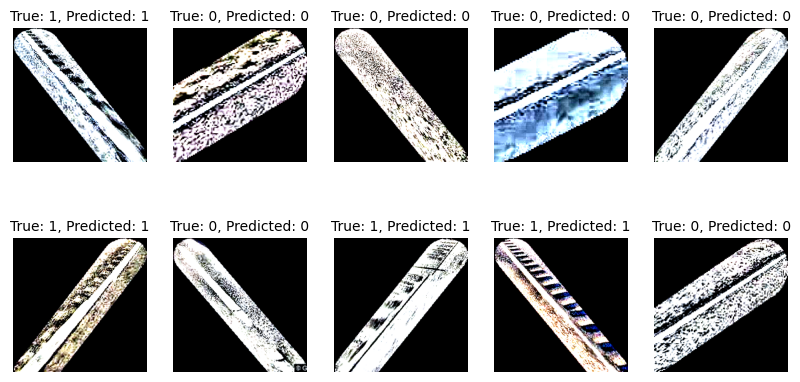

In [32]:
# randomly select 10 images from the validation set and plot them with their predicted labels in 5 x 2 subplots
plt.figure(figsize=(10, 5))
for i in range(10):
    idx = random.randint(0, len(val_data))
    img, label = val_data[idx]
    img = img.unsqueeze(0)
    img = img.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
    plt.subplot(2, 5, i+1)
    plt.imshow(np.transpose(img.squeeze().cpu(), (1, 2, 0)))
    plt.title(f"True: {label}, Predicted: {predicted.item()}", fontsize = 10)
    plt.axis('off')
# plt.savefig('../Roadviewer/TestRes/inference_18.png',dpi = 600)
plt.show()